# Citation

Dataset URL:
https://nihcc.app.box.com/v/ChestXray-NIHCC

Acknowledgements:
NIH Clinical Center for the dataset

Citation:
Wang X, Peng Y, Lu L, Lu Z, Bagheri M, Summers RM. ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases. IEEE CVPR 2017, http://openaccess.thecvf.com/content_cvpr_2017/papers/Wang_ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf

# Structure Data

In [11]:
import pandas as pd

findings_df = pd.read_csv("./data/Data_Entry_2017_v2020.csv")

findings_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168


In [12]:
findings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
dtypes: float64(2), int64(5), object(4)
memory usage: 9.4+ MB


In [13]:
# retain only needed columns
cols_to_retain = ['Image Index',
                  'Finding Labels',]
findings_df = findings_df[cols_to_retain]
findings_df.head()

,Image Index,Finding Labels
0,00000001_000.png,Cardiomegaly
1,00000001_001.png,Cardiomegaly|Emphysema
2,00000001_002.png,Cardiomegaly|Effusion
3,00000002_000.png,No Finding
4,00000003_001.png,Hernia


In [14]:
# create columns for findings we are interested in
findings = ['Pneumothorax',
            'Pneumonia',
            'No Finding']

for finding in findings:
    findings_df[finding] = findings_df['Finding Labels'].str.contains(finding).astype(int)

# All other findings place in column "Other"
findings_df['Other'] = (findings_df[findings].sum(axis=1) == 0).astype(int)

# PRIORITIZE PNEUMOTHORAX: Set 'Pneumonia' to zero where 'Pneumothorax' is 1
findings_df.loc[findings_df['Pneumothorax'] == 1, ['Pneumonia']] = 0

findings_df.head()

,Image Index,Finding Labels,Pneumothorax,Pneumonia,No Finding,Other
0,00000001_000.png,Cardiomegaly,0,0,0,1
1,00000001_001.png,Cardiomegaly|Emphysema,0,0,0,1
2,00000001_002.png,Cardiomegaly|Effusion,0,0,0,1
3,00000002_000.png,No Finding,0,0,1,0
4,00000003_001.png,Hernia,0,0,0,1


In [15]:
# Drop finding labels column
findings_df = findings_df.drop(columns=['Finding Labels'])

findings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Image Index   112120 non-null  object
 1   Pneumothorax  112120 non-null  int64 
 2   Pneumonia     112120 non-null  int64 
 3   No Finding    112120 non-null  int64 
 4   Other         112120 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 4.3+ MB


In [16]:
findings_df.head()

,Image Index,Pneumothorax,Pneumonia,No Finding,Other
0,00000001_000.png,0,0,0,1
1,00000001_001.png,0,0,0,1
2,00000001_002.png,0,0,0,1
3,00000002_000.png,0,0,1,0
4,00000003_001.png,0,0,0,1


In [17]:
# Print counts for each label
labels = ['Pneumothorax',
          'Pneumonia',
          'No Finding',
          'Other']

for label in labels:
    label_sum = findings_df[label].sum()
    print(f"No of {label}: {label_sum}")

No of Pneumothorax: 5302
No of Pneumonia: 1390
No of No Finding: 60361
No of Other: 45067


In [18]:
# Downsample all other labels that more than a threshold to be only that threshhold
from sklearn.utils import resample

threshhold = 6000
labels_to_downsample = []
sampled_dict = dict()

for label in labels:
    label_sum = findings_df[label].sum()

    sub_df = findings_df[findings_df[label] == 1]
    if label_sum > threshhold:
        sampled_dict[label] = resample(sub_df,
                                       replace=False, # no replacement
                                       n_samples=threshhold,
                                       random_state=42)
    else:
        sampled_dict[label] = sub_df

# Combine all downsampled DataFrames
balanced_df = pd.concat(sampled_dict.values())

# Shuffle the dataset to ensure randomness
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

balanced_df.head()

,Image Index,Pneumothorax,Pneumonia,No Finding,Other
0,00013641_004.png,0,1,0,0
1,00000798_025.png,0,1,0,0
2,00010752_010.png,1,0,0,0
3,00012094_004.png,1,0,0,0
4,00014149_020.png,0,1,0,0


In [19]:
balanced_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10390 entries, 0 to 10389
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Image Index   10390 non-null  object
 1   Pneumothorax  10390 non-null  int64 
 2   Pneumonia     10390 non-null  int64 
 3   No Finding    10390 non-null  int64 
 4   Other         10390 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 406.0+ KB


In [21]:
# Print counts for each label
labels = ['Pneumothorax',
          'Pneumonia',
          'No Finding',
          'Other']

for label in labels:
    label_sum = balanced_df[label].sum()
    print(f"No of {label}: {label_sum}")

No of Pneumothorax: 3000
No of Pneumonia: 1390
No of No Finding: 3000
No of Other: 3000


In [22]:
# save resulting dataset
balanced_df.to_csv('./data/binarized_labels.csv', index=False)

# Setup Environment

In [23]:
# Get labels / findings
import pandas as pd

labels_df = pd.read_csv('./data/binarized_labels.csv')

labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10390 entries, 0 to 10389
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Image Index   10390 non-null  object
 1   Pneumothorax  10390 non-null  int64 
 2   Pneumonia     10390 non-null  int64 
 3   No Finding    10390 non-null  int64 
 4   Other         10390 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 406.0+ KB


In [24]:
# Print counts for each label
labels = ['Pneumothorax',
          'Pneumonia',
          'No Finding',
          'Other']

for label in labels:
    sum = labels_df[label].sum()
    print(f"No of {label}: {sum}")

No of Pneumothorax: 3000
No of Pneumonia: 1390
No of No Finding: 3000
No of Other: 3000


In [25]:
# Create a test set
# Randomly select 10 images from each label and place on test_labels.csv
# Define the number of rows to sample
num_samples = 5

# Initialize an empty list to collect the sampled DataFrames
sampled_dfs = []

for label in labels:
    sub_df = labels_df[labels_df[label] == 1]
    if not sub_df.empty:
        sampled_dfs.append(sub_df.sample(n=min(num_samples, len(sub_df))))

# Concatenate all sampled DataFrames into one
test_set_df = pd.concat(sampled_dfs, ignore_index=True)

# Reset the index of the concatenated DataFrame
test_set_df = test_set_df.reset_index(drop=True)

# Print or inspect the resulting DataFrame
test_set_df.head()

,Image Index,Pneumothorax,Pneumonia,No Finding,Other
0,00005140_005.png,1,0,0,0
1,00001331_000.png,1,0,0,0
2,00017972_018.png,1,0,0,0
3,00011379_030.png,1,0,0,0
4,00028897_005.png,1,0,0,0


In [26]:
test_set_df.to_csv('./data/test_set.csv', index=False)

# Check if images are not broken (Optional)

In [18]:
# import libraries
from fastai.vision.all import *

# set path to images
path = Path('/mnt/f/datasets/nihcxr/work')

# unlink broken images
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

## Copying files
- Use copy_files.sh to copy files from images to the appropriate working folders
- Use move_test_files.sh to move images for testing

# Train Model (No Data Augmentation)

In [27]:
# import libraries
from fastai.vision.all import *
import timm # to use efficientnet_b0

# set path to images
path = Path('/mnt/f/datasets/nihcxr/work')

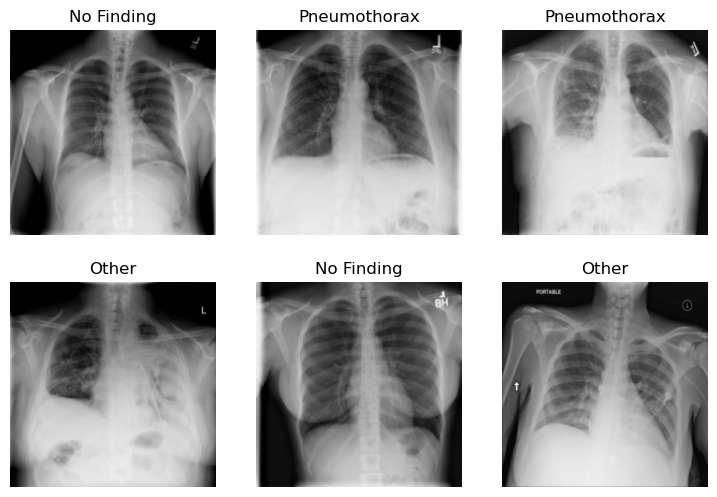

In [28]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [29]:
learn = vision_learner(dls, 'efficientnet_b0', metrics=error_rate)
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.799982,1.441730,0.594986,02:00


epoch,train_loss,valid_loss,error_rate,time
0,1.313950,1.285609,0.566538,01:43
1,1.139848,1.253260,0.547252,01:41


# Analyze Model

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(5, nrows=1, figsize=(17,4))

# Clean Data Model (Optional)

In [ ]:
from fastai.vision.widgets import *

cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
# Execute data cleaning decisions
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

for idx, cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

# Retrain Model on Cleaned Data (Optional)

In [ ]:
# Using the better performing ResNet model
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(3)

# Export Model

In [14]:
learn.export('model.pkl')

# Evaluate on Test Set